✅ DEBUG: Mean Hurst Exponent First 5 values: [0.09737334 0.10590272 0.02305281 0.1379155  0.08398177]
📁 Plot saved at: hurst_exponent_plot.png


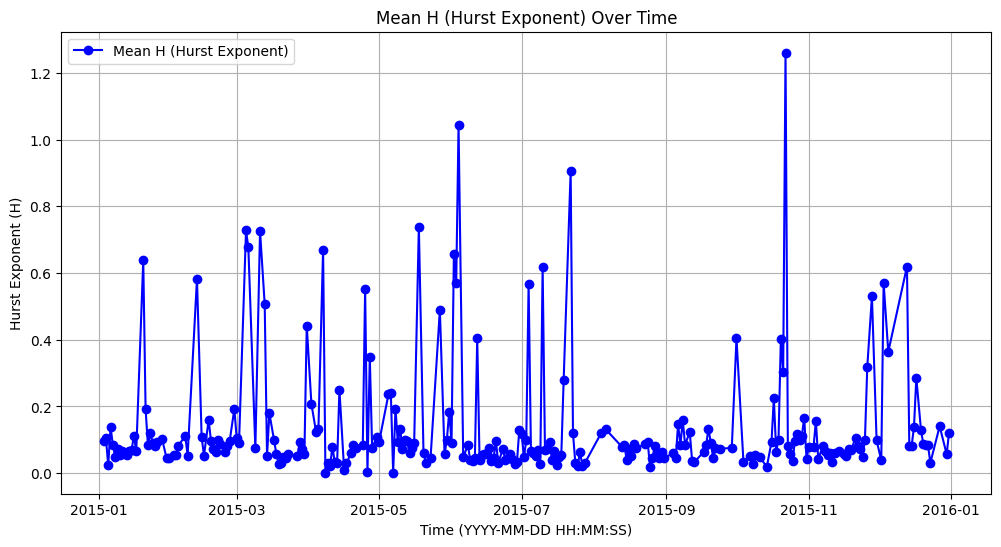

In [1]:
import numpy as np
import pywt
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from skimage.transform import resize
import os
from datetime import timedelta

def load_geomagnetic_data(file_path):
    data = pd.read_csv(file_path, sep=r'\s+', header=None, skiprows=17)
    data.columns = ["Date", "Time", "DOY", "ASY-D", "ASY-H", "SYM-D", "SYM-H"]
    data["Timestamp"] = pd.to_datetime(data["Date"] + " " + data["Time"])
    return data["Timestamp"].values, data["SYM-H"].values

def average_every_n_minutes(timestamps, values, n=3):
    df = pd.DataFrame({"Timestamp": timestamps, "Value": values})
    df.set_index("Timestamp", inplace=True)
    averaged = df.resample(f"{n}min").mean().interpolate()
    return averaged.index.to_numpy(), averaged["Value"].to_numpy()

def compute_wavelet_transform(geomagnetic_index, num_octaves=16, num_voices_per_octave=12):
    wavelet = 'cmor1.5-1.0'
    min_scale = 1
    scales = min_scale * 2 ** (np.arange(num_octaves * num_voices_per_octave) / num_voices_per_octave)
    coefficients, frequencies = pywt.cwt(geomagnetic_index, scales, wavelet, 1)
    return coefficients, frequencies

def normalize_spectrum(power_spectrum):
    return (power_spectrum - np.min(power_spectrum)) / (np.max(power_spectrum) - np.min(power_spectrum))

def apply_frequency_mask(power_spectrum, frequencies, min_freq=1e-5, max_freq=0.5):
    mask = (frequencies >= min_freq) & (frequencies <= max_freq)
    return power_spectrum[mask, :], frequencies[mask]

def compute_hurst_exponents(power_spectrum, frequencies, window_size=32, step_size=8):
    num_time_steps = power_spectrum.shape[1]
    mean_H_over_time = []
    max_H_over_time = []
    min_H_over_time = []
    r_values_over_time = []
    for t in range(num_time_steps):
        log_frequencies = np.log(frequencies)
        log_power = np.log(power_spectrum[:, t] + 1e-10)
        slopes = []
        r_values = []
        for start in range(0, len(log_frequencies) - window_size, step_size):
            end = start + window_size
            slope, _, r_value, _, _ = scipy.stats.linregress(log_frequencies[start:end], log_power[start:end])
            if r_value >= 0.97:
                slopes.append(slope)
                r_values.append(r_value)
        if slopes:
            hurst_exponents = abs((np.array(slopes) - 1) / 2)
            mean_H_over_time.append(np.nanmean(hurst_exponents))
            max_H_over_time.append(np.nanmax(hurst_exponents))
            min_H_over_time.append(np.nanmin(hurst_exponents))
            r_values_over_time.append(np.nanmean(r_values))
    return np.array(mean_H_over_time), np.array(max_H_over_time), np.array(min_H_over_time), np.array(r_values_over_time)

def slice_daily_segments(timestamps, data):
    df = pd.DataFrame({"Timestamp": timestamps, "SYM-H": data})
    df["Date"] = pd.to_datetime(df["Timestamp"]).dt.date
    grouped = df.groupby("Date")
    return [(group["Timestamp"].values, group["SYM-H"].values) for _, group in grouped]

def plot_wavelet_spectrum(timestamps, power_spectrum, frequencies, save_path=None):
    plt.figure(figsize=(12, 6))
    plt.imshow(power_spectrum, aspect='auto', extent=[timestamps[0], timestamps[-1], frequencies[-1], frequencies[0]], cmap='jet')
    plt.colorbar(label="Normalized Wavelet Power")
    plt.xlabel("Time (YYYY-MM-DD HH:MM:SS)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Resized Wavelet Power Spectrum")
    if save_path:
        save_dir = os.path.dirname(save_path)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Spectrogram saved at: {save_path}")
    plt.show()

def save_spectrogram_image(power_spectrum, save_dir, filename="spectrogram.png"):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_path = os.path.join(save_dir, filename)
    plt.imsave(save_path, power_spectrum, cmap='jet')
    print(f"Spectrogram image saved at: {save_path}")

def plot_hurst_exponent(timestamps, hurst_exponents, exponent_type="mean", save_path="hurst_exponent_plot.png"):
    if len(hurst_exponents) == 0:
        print("❌ ERROR: No Hurst exponent values found. Check computation!")
        return
    plt.figure(figsize=(12, 6))
    if exponent_type == "mean":
        hurst_values = hurst_exponents
        label = r'Mean H (Hurst Exponent)'
        color = 'b'
    elif exponent_type == "min":
        hurst_values = hurst_exponents
        label = r'Min H (Hurst Exponent)'
        color = 'g'
    else:
        print("❌ ERROR: Invalid `exponent_type` value! Supported: 'mean', 'min'.")
        return
    print(f"✅ DEBUG: {exponent_type.capitalize()} Hurst Exponent First 5 values: {hurst_values[:5]}")
    timestamps = timestamps[:len(hurst_values)]
    plt.plot(timestamps, hurst_values, marker='o', linestyle='-', color=color, label=label)
    plt.xlabel("Time (YYYY-MM-DD HH:MM:SS)")
    plt.ylabel("Hurst Exponent (H)")
    plt.title(f"{label} Over Time")
    plt.legend()
    plt.grid()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"📁 Plot saved at: {save_path}")
    plt.show()

# Pipeline Execution
file_path = "KyotoSymhYear2015.dat"
timestamps, geomagnetic_index = load_geomagnetic_data(file_path)

# ✅ Step 1: Average every 3 minutes
timestamps, geomagnetic_index = average_every_n_minutes(timestamps, geomagnetic_index, n=3)

# ✅ Step 2: Slice daily
daily_segments = slice_daily_segments(timestamps, geomagnetic_index)

# ✅ Step 3: Compute Hurst exponents daily
mean_hurst_all = []
plot_timestamps = []

for ts_slice, data_slice in daily_segments:
    coeffs, freqs = compute_wavelet_transform(data_slice)
    spectrum = np.abs(coeffs) ** 2
    norm_spectrum = normalize_spectrum(spectrum)
    masked_spectrum, masked_freqs = apply_frequency_mask(norm_spectrum, freqs, min_freq=1e-5, max_freq=1e-1)
    mean_hurst, _, _, _ = compute_hurst_exponents(masked_spectrum, masked_freqs)
    if len(mean_hurst) > 0:
        mean_hurst_all.append(np.mean(mean_hurst))
        plot_timestamps.append(ts_slice[0])

plot_hurst_exponent(plot_timestamps, np.array(mean_hurst_all), exponent_type="mean")
